In [82]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [84]:
import bnn.functions
import bnn.network
import bnn.layer
import bnn.loss
import bnn.optimizer

In [85]:
dims = [1, 10, 10, 4]
TBNN = bnn.network.TernBinNetwork(
    *dims,
    forward_func=bnn.functions.forward.LayerMeanBinarise(),
    backward_func=bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=1),
    #backward_func=bnn.functions.backward.LayerQuantileTernarise(lo=0.2, hi=0.8),
)

In [86]:
TBNN._initialise(W_mean=0, W_zero_prob=1)

In [87]:
samples = 100
input = bnn.functions.binarise(torch.randn(samples, 1).to(torch.int))
desired = torch.stack(
    [input[..., 0], -input[..., 0], torch.ones(samples, dtype=torch.int), -torch.ones(samples, dtype=torch.int)], dim=-1
)
desired.shape

torch.Size([100, 4])

In [88]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [89]:
train_epochs = 1000

In [90]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=0.0001)

In [91]:
losses = []
for epoch in range(train_epochs):
    # forward pass
    output = TBNN.forward(input)
    loss = loss_func.forward(output=output, target=desired)
    losses.append(loss)

    # backward pass
    grad = loss_func.backward(output=output, target=desired)
    out_grad = TBNN.backward(grad)

    # optimizer step
    BernOpt.step(number_of_samples=len(input))

    early_exit = loss == 0

    if early_exit or (epoch % 10) == 0:
        print(f'epoch: {epoch}\tloss: {loss}')

    if early_exit:
        break

epoch: 0	loss: 400
epoch: 10	loss: 200
epoch: 20	loss: 68
epoch: 30	loss: 68
epoch: 40	loss: 200
epoch: 50	loss: 468
epoch: 60	loss: 68
epoch: 70	loss: 68
epoch: 80	loss: 68
epoch: 90	loss: 68
epoch: 100	loss: 268
epoch: 110	loss: 68
epoch: 120	loss: 400
epoch: 130	loss: 200
epoch: 140	loss: 68
epoch: 150	loss: 68
epoch: 160	loss: 200
epoch: 170	loss: 200
epoch: 180	loss: 200
epoch: 190	loss: 68
epoch: 200	loss: 68
epoch: 210	loss: 400
epoch: 220	loss: 68
epoch: 230	loss: 68
epoch: 240	loss: 234
epoch: 250	loss: 400
epoch: 260	loss: 234
epoch: 270	loss: 332
epoch: 280	loss: 332
epoch: 290	loss: 200
epoch: 300	loss: 200
epoch: 310	loss: 200
epoch: 320	loss: 68
epoch: 327	loss: 0


In [92]:
TBNN.forward(-torch.ones(1, 1, dtype=torch.int))

tensor([[-1,  1,  1, -1]], dtype=torch.int32)

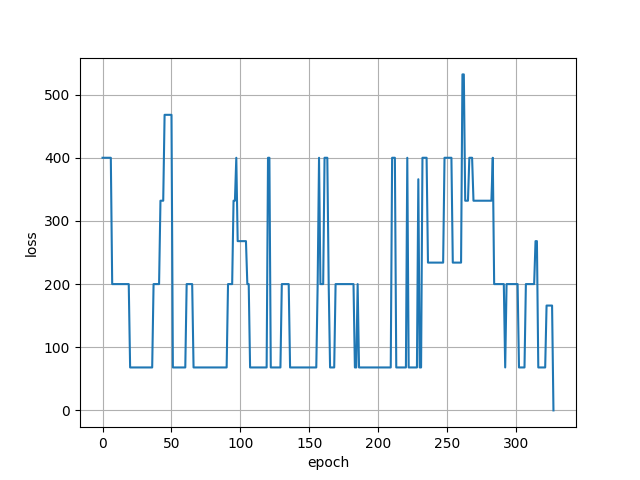

In [93]:
NAME = 'loss_curve'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

In [94]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, p)

layers.TernBinLayer0.W Parameter containing:
tensor([[ 0,  1,  0,  0,  1,  0,  0,  0,  0, -1]], dtype=torch.int32)
layers.TernBinLayer1.W Parameter containing:
tensor([[-1, -1,  0,  0,  0,  0,  1, -1,  0, -1],
        [-1,  0,  0,  0,  1,  0,  1, -1,  0,  1],
        [ 0, -1,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0, -1,  0,  0,  0, -1, -1,  0,  0,  1],
        [ 0,  1,  0,  0,  1,  0,  1,  0,  0,  0],
        [ 0,  0, -1,  0,  1,  1,  0, -1,  0,  0],
        [ 0,  0,  0,  0,  0, -1,  0, -1,  0,  0],
        [ 0,  1,  0,  0,  0,  0, -1, -1,  0,  0],
        [-1,  0, -1,  0,  0,  0,  0,  1,  0,  0],
        [ 1,  0,  1,  0,  1,  0, -1,  1,  0,  0]], dtype=torch.int32)
layers.TernBinLayer2.W Parameter containing:
tensor([[ 1,  1, -1, -1],
        [ 0,  0,  1,  0],
        [ 0,  0,  0,  1],
        [ 0,  0,  1,  0],
        [ 0, -1,  1,  1],
        [ 0,  0,  0, -1],
        [ 1, -1,  0,  1],
        [ 0,  1,  1,  0],
        [-1,  0,  0,  0],
        [ 0,  0,  0, -1]], dtype=torch.in